<h1>Оглавление<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Загрузка-данных" data-toc-modified-id="Загрузка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Загрузка данных</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Исследовательский-анализ-данных" data-toc-modified-id="Исследовательский-анализ-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Исследовательский анализ данных</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Модель-прогнозирования-оттока-клиентов" data-toc-modified-id="Модель-прогнозирования-оттока-клиентов-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Модель прогнозирования оттока клиентов</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Кластеризация-клиентов" data-toc-modified-id="Кластеризация-клиентов-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Кластеризация клиентов</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Общий-вывод" data-toc-modified-id="Общий-вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Общий вывод</a></span></li></ul></div>

# Прогнозирование оттока клиентов сети фитнес-центров «Культурист-датасаентист»

Чтобы подготовить план действий по удержанию клиентов фитнес-клуба, изучим массив клиентских анкет. В ходе работы спрогнозируем вероятность оттока для каждого клиента, сформируем типичные портреты клиентов, проанализируем влияющие на отток признаки и разработаем рекомендации по повышению качества работы с клиентами.

## Загрузка данных

Импортируем все библиотеки, которые потребуются нам в дальнейшей работе:

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from scipy.cluster.hierarchy import dendrogram, linkage 
from sklearn.cluster import KMeans
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')

Прочитаем файл и ознакомимся с его содержимым:

In [2]:
path = r"c:\users\79215\desktop\project\\"
try:
    gym_churn = pd.read_csv(path + 'gym_churn.csv', sep=',')
except:
    gym_churn = pd.read_csv('/datasets/gym_churn.csv', sep=',')

gym_churn.columns = [x.lower() for x in gym_churn.columns.values] #приведение всех знаков в заголовках колонок к строчному виду
display(gym_churn.head())
gym_churn.info()

print('\n' + 'Количество дубликатов:', gym_churn.duplicated().sum())

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   near_location                      4000 non-null   int64  
 2   partner                            4000 non-null   int64  
 3   promo_friends                      4000 non-null   int64  
 4   phone                              4000 non-null   int64  
 5   contract_period                    4000 non-null   int64  
 6   group_visits                       4000 non-null   int64  
 7   age                                4000 non-null   int64  
 8   avg_additional_charges_total       4000 non-null   float64
 9   month_to_end_contract              4000 non-null   float64
 10  lifetime                           4000 non-null   int64  
 11  avg_class_frequency_total          4000 non-null   float

### Вывод

Итак, в нашей таблице отсутствуют пропуски и дубликаты, а все колонки имеют количественные значения (`int` или `float`). Наименования столбцов указаны в корректном "змеином" регистре, но для собственного удобства мы дополнительно привели все буквы в заголовках к строчному виду. Более предобработки не требуется, поэтому можно приступать к анализу имеющихся данных. 

## Исследовательский анализ данных

Посмотрим на описание данных по всем параметрам: 

In [3]:
gym_churn.describe().round(2).T

,count,mean,std,min,25%,50%,75%,max
gender,4000.0,0.51,0.50,0.00,0.00,1.00,1.00,1.00
near_location,4000.0,0.85,0.36,0.00,1.00,1.00,1.00,1.00
partner,4000.0,0.49,0.50,0.00,0.00,0.00,1.00,1.00
promo_friends,4000.0,0.31,0.46,0.00,0.00,0.00,1.00,1.00
phone,4000.0,0.90,0.30,0.00,1.00,1.00,1.00,1.00
contract_period,4000.0,4.68,4.55,1.00,1.00,1.00,6.00,12.00
group_visits,4000.0,0.41,0.49,0.00,0.00,0.00,1.00,1.00
age,4000.0,29.18,3.26,18.00,27.00,29.00,31.00,41.00
avg_additional_charges_total,4000.0,146.94,96.36,0.15,68.87,136.22,210.95,552.59
month_to_end_contract,4000.0,4.32,4.19,1.00,1.00,1.00,6.00,12.00


По полученным значениям мы можем сделать следующие выводы:
- среди клиентов фитнес-клуба **примерно равное количество мужчин и женщин**;
- клиенты клуба - в возрасте **от 18 до 41 года** (средний возраст - 29-30 лет);
- основная масса клиентов **(85%) живут или работают в районе, где находится фитнес-центр**;
- около **половины клиентов фитнес-центра - сотрудники компании-партнёра клуба**;
- примерно **треть клиентов пришло по акции "Приведи друга"**;
- только **10% клиентов не оставили свой номер телефона**;
- большинство клиентов покупают **абонемент на 1 месяц**;
- на групповые занятия ходит около 40% клиентов;
- в среднем клиенты посещают фитнес-центр **пару раз в неделю**;
- в текущем месяце **отток клиентов составляет 27%**.

Сравним, как отличаются средние показатели для клиентов, покинувших фитнес-клуб, и для тех, кто остался:

In [4]:
gym_churn.groupby('churn').mean().round(2)

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month
churn,,,,,,,,,,,,,
0,0.51,0.87,0.53,0.35,0.9,5.75,0.46,29.98,158.45,5.28,4.71,2.02,2.03
1,0.51,0.77,0.36,0.18,0.9,1.73,0.27,26.99,115.08,1.66,0.99,1.47,1.04


Итак, в данном сравнении в глаза бросаются следующие факты относительно клиентов, покинувших клуб:
- **эти клиенты моложе тех, кто остался** (27 лет против 30);
- среди них **меньше сотрудников компании-партнёра клуба и пришедших в рамках акции "Приведи друга"**;
- такие клиенты **реже посещают групповые занятия** и **тратят меньше денег на дополнительные услуги**;
- они **чаще приобретают абонементы на короткий срок (1 месяц)** и перестают пользоваться услугами фитнес-центра, когда **до окончания действия абонемента остаётся не так много времени** (1-2 месяца);
- так как ушедшие клиенты являются держателями краткосрочных абонементов, то и среднее время с момента первого обращения в фитнес-центр у таких клиентов почти в пять раз меньше;
- в среднем, клиенты покинувшие фитнес-центр, **посещали его реже остальных - около 1 раза в неделю**.

Посмотрим на параметры двух групп (те, кто ушёл, и те, кто остался) на гистограммах:

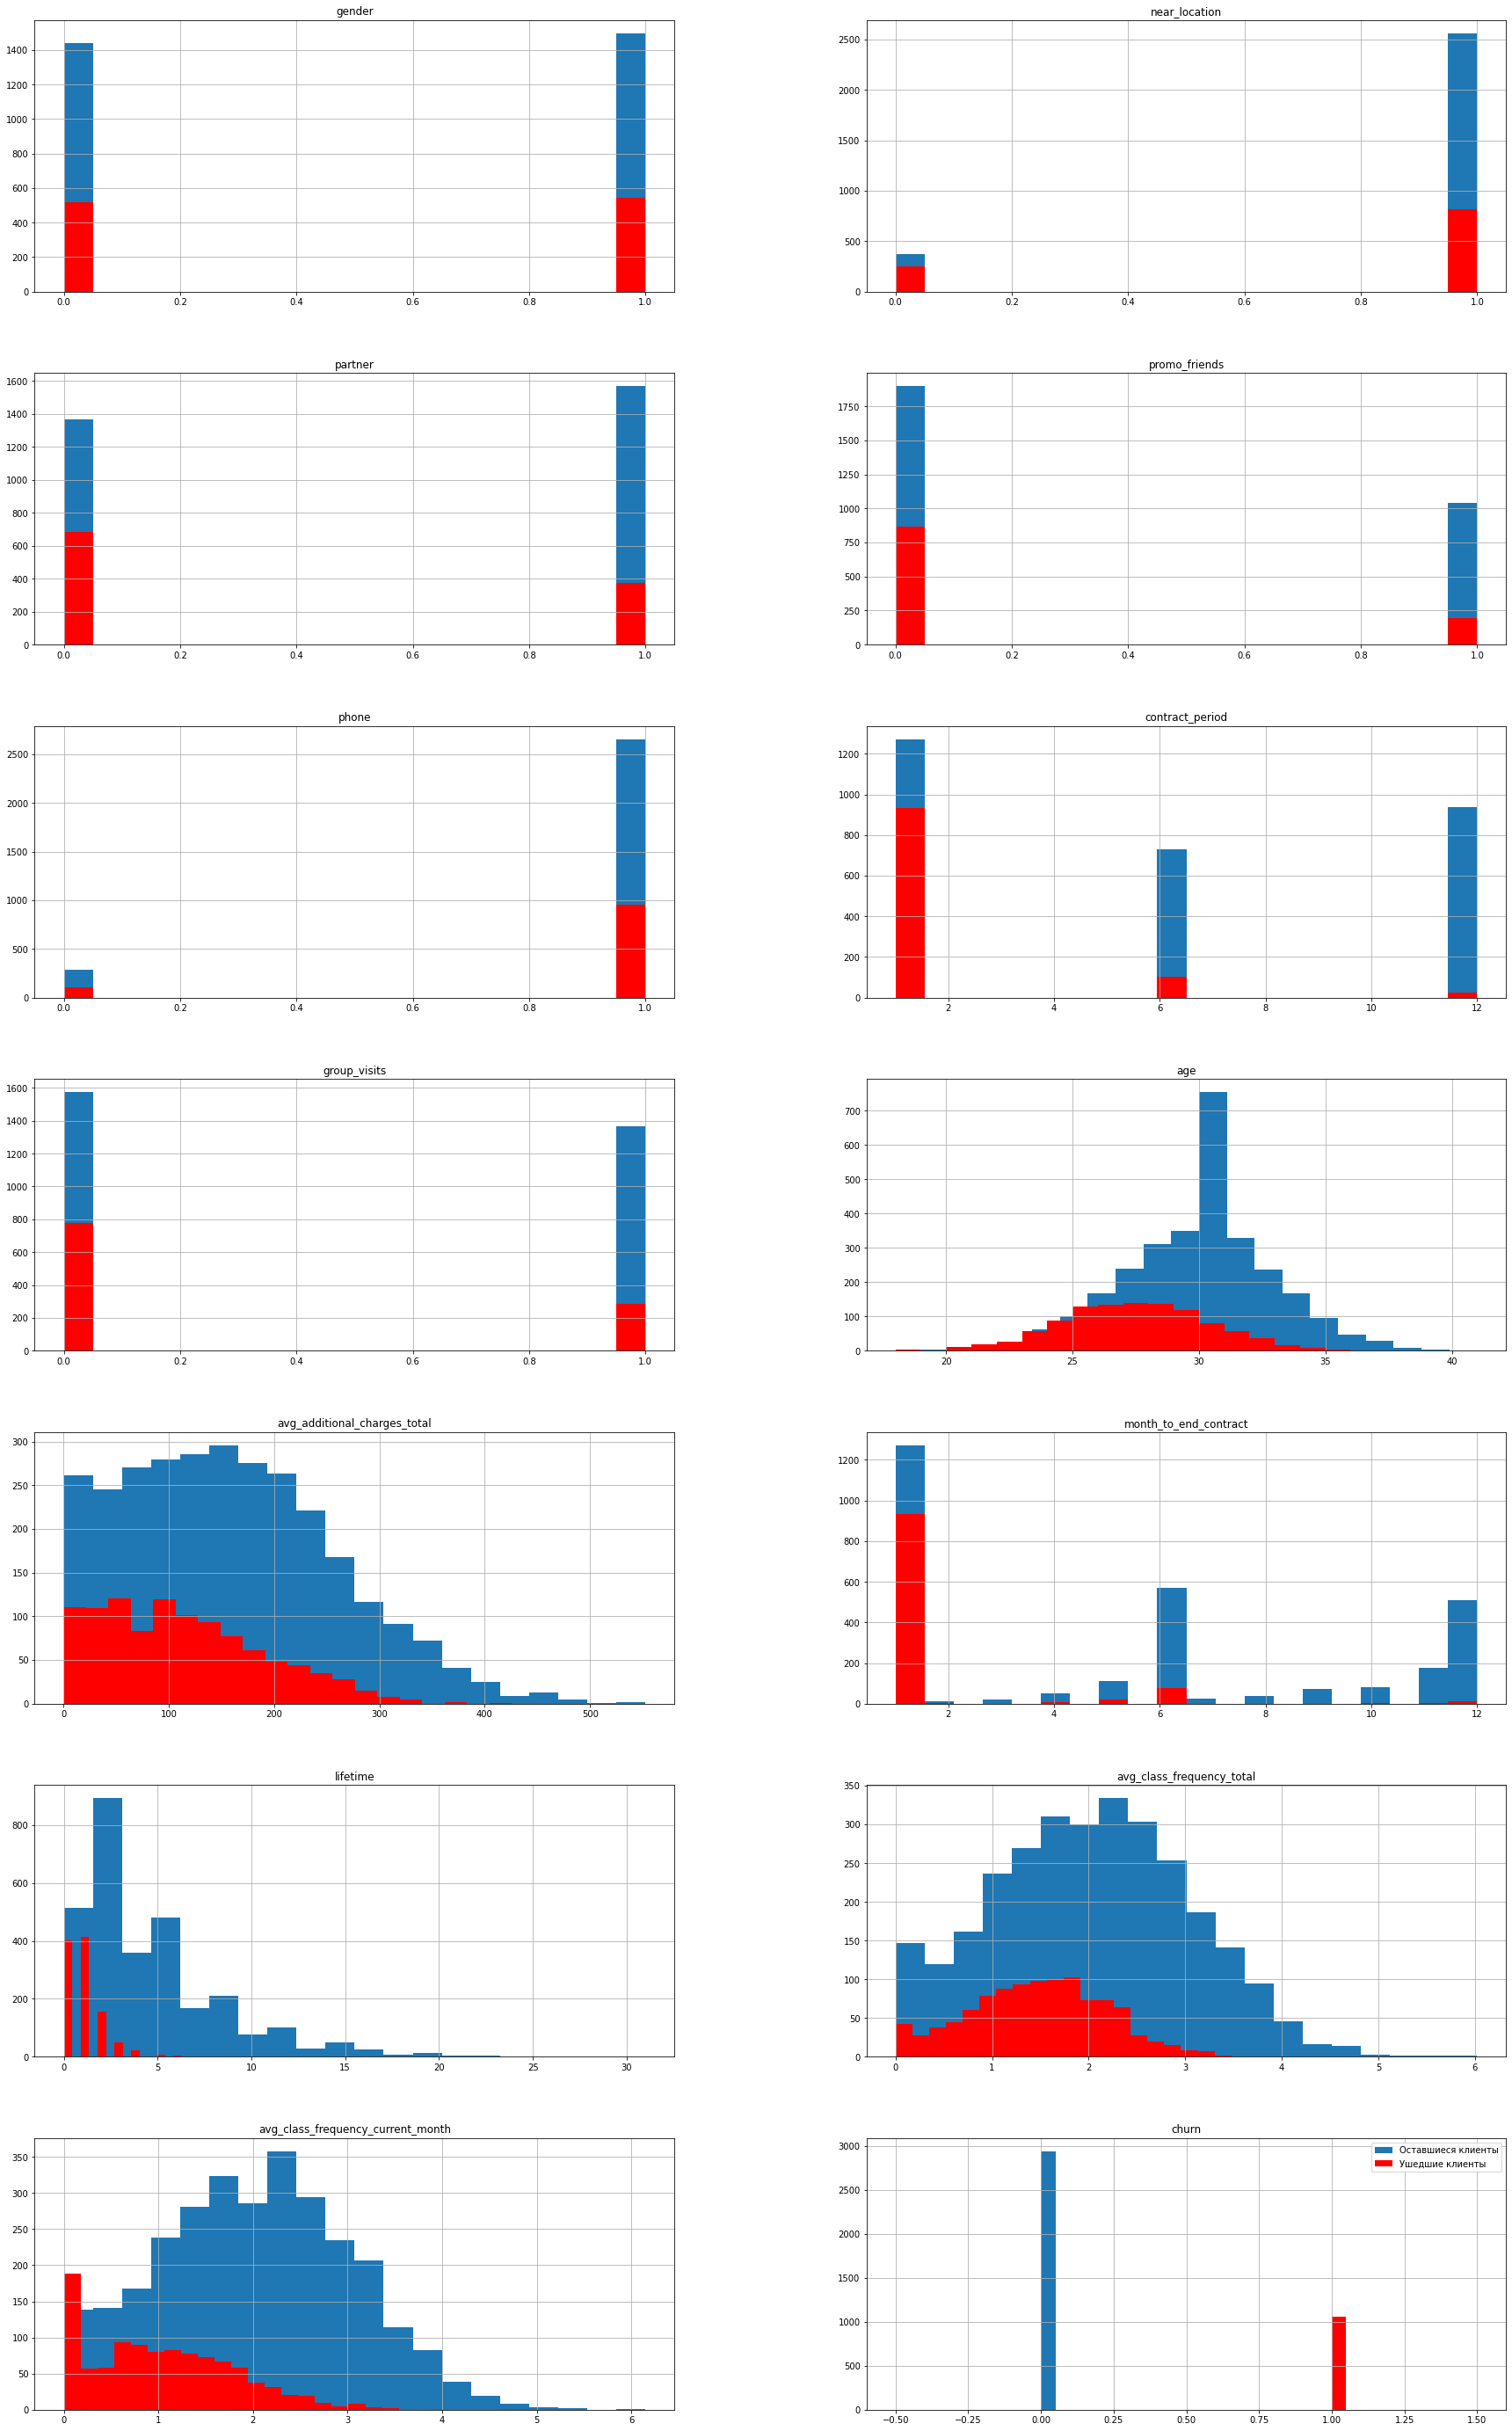

In [5]:
fig, axs = plt.subplots(7,2, figsize=(30, 50))
gym_churn.query('churn == 0').hist(ax=axs, bins=20, label='Оставшиеся клиенты')
gym_churn.query('churn == 1').hist(ax=axs, bins=20, color='red', label='Ушедшие клиенты')
plt.legend()
plt.show()

Благодаря графикам, мы имеем возможность конкретизировать наши предварительные выводы:
- ушедшие клиенты моложе оставшихся: 25-30 лет против 28-32 лет;
- ушедшие клиенты меньше тратят на дополнительные услуги: 50-150 против 100-200;
- с первого обращения в фитнес-центр ушедших клиентов обычно не проходит более полугода, в то время как среди оставших есть настоящие старожилы;
- среди ушедших клиентов очень мало держателей абонементов на длительный срок, в то время как у оставшихся клиентов много абонементов на полгода/год, соответственно по этой же причине срок окончания действия абонемента у ушедших клиентов редко превышает месяц;
- ушедшие клиенты в массе своей реже посещали фитнес-центр: 1-2 раза в неделю против 2-3 раз.

Ещё один важный факт, который продемонстрировал нам график и на который стоит обратить наше внимание - **большое количество ушедших клиентов в последний месяц не посещали фитнес-центр**.

Изучим корреляцию факторов:

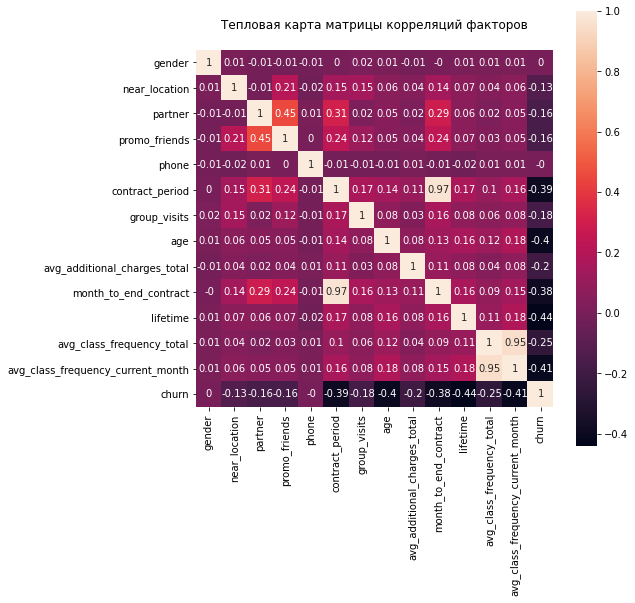

In [6]:
plt.figure(figsize=(8,8))
sns.heatmap(gym_churn.corr().round(2), annot=True, square=True)
plt.title('Тепловая карта матрицы корреляций факторов' + '\n')
plt.show()

Как мы видим, **самая высокая корреляция между длительностью абонемента и сроком до его окончания**, что логично - если абонемент приобретен всего на месяц (а таких абонементов, как мы уже выяснили, большинство), то и срок до окончания его действия больше месяца быть не может.

Также **высокая корреляция у средней частоты посещений в неделю за все время и за последний месяц**. Что тоже объяснимо - гистограммы нам продемонстрировали, что в последний месяц поведение меняется только у тех клиентов, кто отказывается от услуг фитнес-центра. Остальные продолжают посещать фитнес-клуб с привычной периодичностью.

In [7]:
gym_churn = gym_churn.drop('month_to_end_contract', axis = 1)

### Вывод

Первичный анализы позволил сделать нам следующие предварительные выводы:
- более молодые клиенты чаще оказываются в группе "оттока", чем клиенты постарше;
- ушедшие клиенты чаще приобретают абонементы на короткий срок (1 месяц);
- они реже остальных ходят в фитнес-центр (около 1 раза в неделю), а в последний месяц не посещают его вовсе;
- среди клиентов группы "оттока" меньше сотрудников компании-партнёра клуба и пришедших по акции "Приведи друга";
- также они реже посещают групповые занятия и меньше тратятся на дополнительные услуги;
- самая высокая корреляция между длительностью абонемента и сроком до его окончания, а также между средней частотой посещений в неделю за все время и за последний месяц.

## Модель прогнозирования оттока клиентов

Построим модель бинарной классификации клиентов, где целевой признак — факт оттока клиента в следующем месяце:

In [8]:
X = gym_churn.drop('churn', axis = 1) # объявление матрицы X (признаки)
y = gym_churn['churn'] # объявление целевой переменной y

# разделение модели на обучающую и валидационную выборки функцией train_test_split():
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=0) 

# обучение модели на train-выборке способом логистической регрессии:
model = LogisticRegression(solver='liblinear', C=5.0)
model.fit(X_train, y_train)
predictions = model.predict(X_test)
probabilities = model.predict_proba(X_test)[:, 1]

# обучение модели на train-выборке способом случайного леса:
rf_model = RandomForestClassifier(random_state = 0) 
param_grid = {'n_estimators': range(100,1000,100), 'max_depth': range(10,100,10)}
rf_model = GridSearchCV(rf_model, param_grid)
rf_model.fit(X_train, y_train)
rf_predictions = rf_model.predict(X_test) 
rf_probabilities = rf_model.predict_proba(X_test)[:, 1]

# объявление функции для расчёта метрик accuracy, precision и recall:
def print_all_metrics(y_true, y_pred, y_proba, title):
    print(title)
    print('\tAccuracy: {:.2f}'.format(accuracy_score(y_true, y_pred)))
    print('\tPrecision: {:.2f}'.format(precision_score(y_true, y_pred)))
    print('\tRecall: {:.2f}'.format(recall_score(y_true, y_pred)))
    print('\tF1: {:.2f}'.format(f1_score(y_true, y_pred)))
    print('\tROC_AUC: {:.2f}'.format(roc_auc_score(y_true, y_proba)))

print(rf_model.best_params_)
print_all_metrics(y_test, predictions, probabilities, 'Метрики для модели логистической регрессии:')
print_all_metrics(y_test, rf_predictions, rf_probabilities, 'Метрики для модели случайного леса:')

{'max_depth': 20, 'n_estimators': 700}
Метрики для модели логистической регрессии:
	Accuracy: 0.93
	Precision: 0.90
	Recall: 0.85
	F1: 0.87
	ROC_AUC: 0.98
Метрики для модели случайного леса:
	Accuracy: 0.93
	Precision: 0.89
	Recall: 0.83
	F1: 0.86
	ROC_AUC: 0.97


### Вывод

Итак, для обеих моделей метрики `accuracy, precision, recall, F1 и ROC_AUC` имеют хорошие показатели, но **модель логистической регрессии в данном случае продемонстрировала себя несколько лучше**. 

## Кластеризация клиентов

Теперь займемся кластеризацией клиентов по имеющимся у нас признакам. Для этого сначала стандартизируем данные (X) и нарисуем дендрограмму:

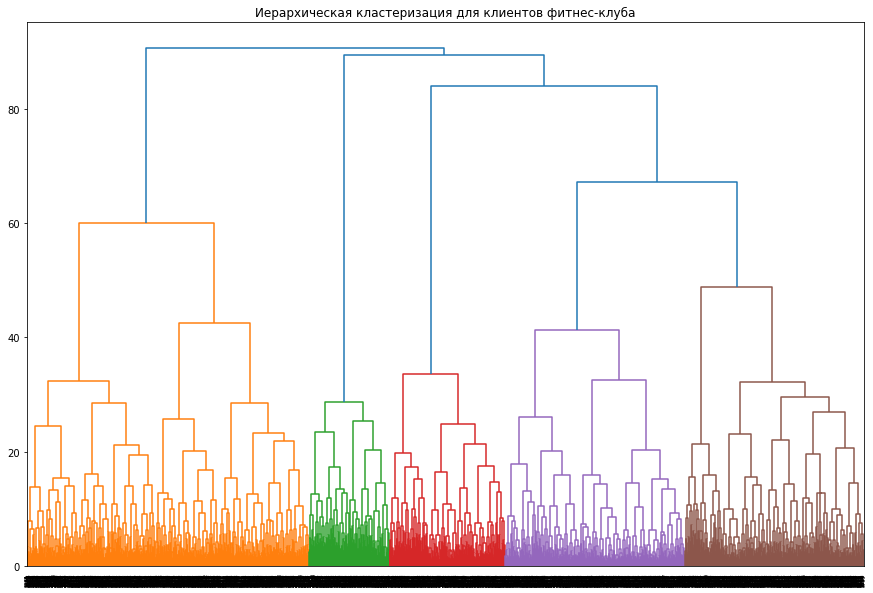

In [9]:
# стандартизация данных:
sc = StandardScaler()
X_sc = sc.fit_transform(X)

# построение матрицы расстояний функцией linkage() на стандартизованной матрице признаков:
linked = linkage(X_sc, method = 'ward') 

# построение дендрограммы:
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.title('Иерархическая кластеризация для клиентов фитнес-клуба')
plt.show()

Согласно полученному графику, можно предположить, что **оптимальное число кластеров 5** - по пяти разным цветам на графике.

Возьмём за число кластеров `5` и обучим модель кластеризации на основании алгоритма K-Means:

In [10]:
km = KMeans(n_clusters=5, random_state=0)
labels = km.fit_predict(X_sc)

Посмотрим на средние показатели всех признаков для разных кластеров. Для этого добавим в нашу таблицу столбец `cluster_km` со значениями кластеров:

In [11]:
gym_churn['cluster_km'] = labels
gym_churn.groupby('cluster_km').mean().round(2)

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
cluster_km,,,,,,,,,,,,,
0,0.48,0.99,0.95,0.88,1.0,7.83,0.54,29.63,154.79,4.45,1.84,1.80,0.10
1,0.52,0.86,0.47,0.31,0.0,4.76,0.43,29.28,144.24,3.92,1.85,1.72,0.27
2,0.49,1.00,0.24,0.10,1.0,2.48,0.33,28.22,131.34,2.44,1.26,1.03,0.50
3,0.57,0.97,0.31,0.10,1.0,5.14,0.48,30.29,166.18,5.01,2.88,2.88,0.04
4,0.50,0.00,0.49,0.08,1.0,2.86,0.23,28.57,136.38,2.91,1.67,1.50,0.42


По средним значениям можно сделать следующие выводы:
- `кластер 0` характеризуется высокой долей сотрудников компании-партнёра клуба (95%) и пришедших по акции "Приведи друга", также они чаще остальных приобретают долгосрочные абонементы и посещают групповые занятия;
- все клиенты `кластера 1` не указали в анкете свой номер телефона, остальные их показатели не сильно выделяются;
- все клиенты `кластера 2` живут или работают в районе расположения фитнес-центра, среди них меньше всего сотрудников компании-партнёра клуба, они в основном приобретают краткосрочные абонементы. По возрасту это самая молодая группа, они меньше других тратят на доп.услуги и реже остальных посещают фитнес-центр;
- в `кластере 3` оказались самые взрослые клиенты с самыми крупными тратами на доп.услуги, дольше и чаще остальных занимающиеся в клубе;
- в `кластере 4` все клиенты живут не в районе расположения фитнес-центра, среди них самое малое участников акции "Приведи друга", также они реже остальных посещают групповые занятия;

Также в данной таблице со средними значениями в столбце `churn` зафиксирована доля оттока для каждого полученного кластера. Посмотрим на эти показатели отдельно:

In [12]:
gym_churn.groupby('cluster_km')['churn'].mean().round(2)

cluster_km
0    0.10
1    0.27
2    0.50
3    0.04
4    0.42
Name: churn, dtype: float64

По этим данным можно предположить, что **клиенты из кластеров `2 и 4` склонны к оттоку, а клиенты из кластеров `3 и 0` наиболее надёжны**.

Визуализируем распределения признаков для кластеров. Но для признаков с бинарными и множественными значениями мы будем строить разные типы графиков, поэтому поделим их на две группы, для каждой объявим функции отрисовки графиков и передадим им соответствующие списки с наименованиями столбцов: 

<Figure size 360x360 with 0 Axes>

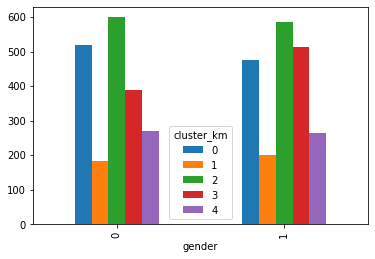

<Figure size 360x360 with 0 Axes>

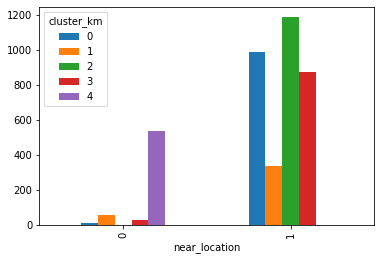

<Figure size 360x360 with 0 Axes>

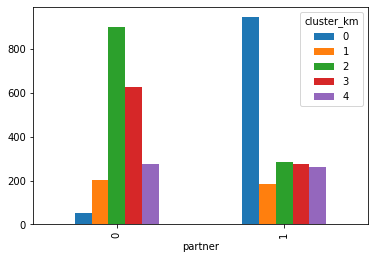

<Figure size 360x360 with 0 Axes>

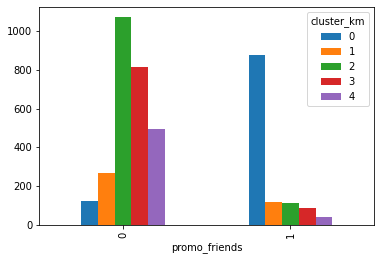

<Figure size 360x360 with 0 Axes>

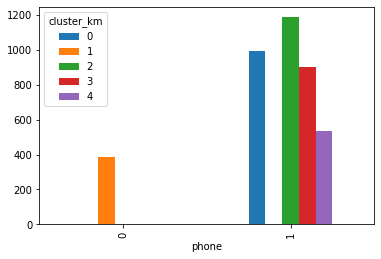

<Figure size 360x360 with 0 Axes>

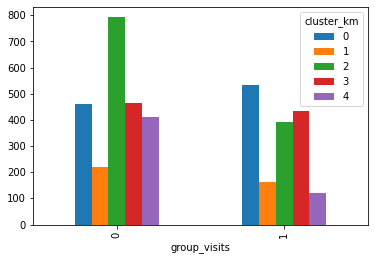

<Figure size 360x360 with 0 Axes>

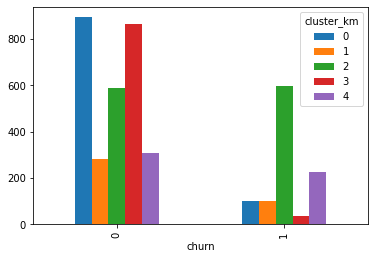

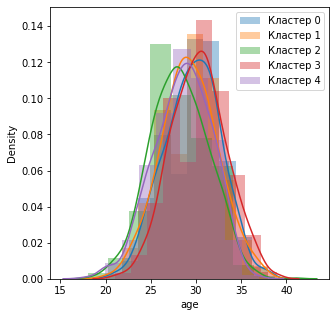

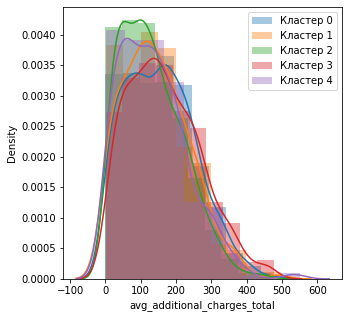

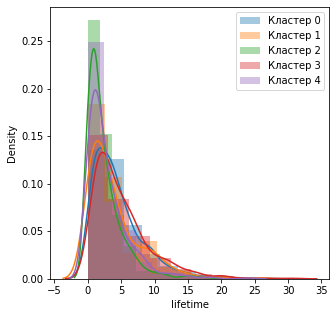

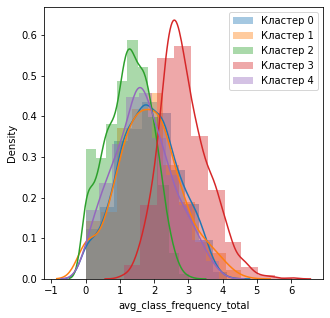

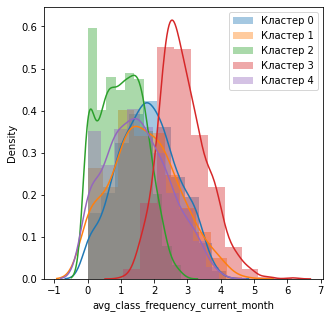

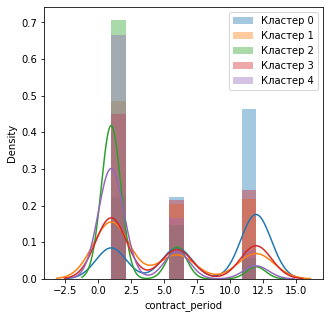

In [13]:
# список наименований колонок с бинарными значениями:
bi_columns = ['gender', 'near_location', 'partner', 'promo_friends', 'phone', 'group_visits', 'churn']

# список наименований колонок с множественными значениями:
columns = ['age', 'avg_additional_charges_total', 'lifetime', 'avg_class_frequency_total', 'avg_class_frequency_current_month', 'contract_period']

# объявление функции отрисовки графиков для признаков с бинарными значениями:
def plot(df, column):
    plt.figure(figsize=(5, 5))
    df.pivot_table(index = column, columns = 'cluster_km', values = 'age', aggfunc = 'count').plot(kind='bar')
    plt.show()

# объявление функции отрисовки графиков для признаков с множественными значениями:
def distplot(df, column):
    plt.figure(figsize=(5, 5))
    sns.distplot(df.query('cluster_km == 0')[column], bins=10, label='Кластер 0')
    sns.distplot(df.query('cluster_km == 1')[column], bins=10, label='Кластер 1')
    sns.distplot(df.query('cluster_km == 2')[column], bins=10, label='Кластер 2')
    sns.distplot(df.query('cluster_km == 3')[column], bins=10, label='Кластер 3')
    sns.distplot(df.query('cluster_km == 4')[column], bins=10, label='Кластер 4')
    plt.legend()
    plt.show()
    
for column in bi_columns:
    plot(gym_churn, column)

for column in columns:
    distplot(gym_churn, column)

### Вывод

Мы определили, что наиболее надёжные клиенты, это те, кого, можно отнести **к кластерам 0 и 3**. Согласно полученным графикам, таким клиентам характерны следующие признаки:
- приобретают долгосрочные абонементы;
- посещают спорт-клуб 2-3 раза в неделю;
- постарше клиентов других кластеров (около 30 лет);
- чаще остальных ходят на групповые занятия;
- тратят бОльшие суммы на дополнительные услуги;
- являются сотрудниками компании-партнёра клуба или участниками акции "Приведи друга".

Одним словом, покупка долгосрочного абонемента демонстрирует решительность клиента и его уверенность в собственных силах. Это человек, заинтересованный в спорте, и активно вовлеченный в жизнь фитнес-центра. Также наличие длительного абонемента позволяет спокойно вернуться к посещению фитнес-центра даже после паузы. Отдельно стоит отметить, что среди клиентов этих кластеров много сотрудников компании-партнёра клуба и участников акции "Приведи друга" - это может значить, что поход в спорт-зал с друзьями/коллегами может являться дополнительной мотивацией и сдерживающим фактором от того, чтобы бросить походы в фитнес-центр.

Склонным к оттоку клиентам **из кластеров 2 и 4** свойствены следующие характеристики:
- приобретение краткосрочных абонементов (на 1 месяц);
- посещение спорт-клуба около 1 раза в неделю;
- трата меньших суммы на дополнительные услуги;
- меньший возраст - 25-30 лет.

Приобретение краткосрочного абонемента часто означает желание попробовать услуги фитнес-центра, спорта в принципе или "начать новую жизнь с понедельника". За несколько недель новичок не успевает "втянуться", войти в режим, поэтому отток в какой-то степени предсказуем. Чтобы адаптироваться к новым условиям, клиенту нужна помощь фитнес-центра, если тот, в свою очередь, намерен этого клиента удержать.

## Общий вывод

Мы изучили анкеты клиентов сети фитнес-центров «Культурист-датасаентист», проанализировали влияющие на отток признаки, сформировали портрет целевого клиента и теперь можем дать ряд рекомендаций по повышению качества работы с клиентами:
- необходимо **стимулировать приобретение долгосрочных абонементов** - например, по окончании месячного абонемента предлагать клиенту полугодовое посещение на особо привлекательных условиях, или разработать компромиссные абонементы на 3 месяца, которые по стоимости будут выгоднее краткосрочных предложений;
- есть смысл **вовлекать клиентов в дополнительные услуги фитнес-центра** и во все имеющиеся направления (в том числе, групповые занятия) - к примеру, новым клиентам выдавать "пакет новичка", включающий в себя пробные бесплатные занятия/услуги/консультации, некоторые из них смогут заинтересовать клиента и удержать его в клубе;
- стоит **отслеживать частотность посещений клиентов** и, если в течение месяца клиент не посещал фитнес-центр, связаться с ним, пока он не ушёл в "отток";
- опыт целевого кластера продемонстрировал **успех акции "Приведи друга" и взаимодействия с сотрудниками компании-партнёра клуба**, поэтому стоит активнее развивать эти направления (может, особые условия для "семейных" абонементов или приобретение новых компаний-партнёров).